<a href="https://colab.research.google.com/github/FlorianSong/Intro_data_analytics/blob/master/Workshop4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analytics 2019
### Workshop 4 &ndash; Artificial Neural Networks: a whistle stop introduction &ndash; 21st Nov 2019
##### Taught by: Florian Song, Sophia Yaliraki

Much of today's workshop was taken from https://github.com/ageron/handson-ml2/ which in turn is based on the second edition of an O'Reilly book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Geron.

### Overview & Outline


#### Topics covered today:
0. Choosing the right estimator
1. Artificial Neural Networks 
    * Biological vs artificial neurons
    * Perceptrons
    * Multi-layer perceptrons
1. Implementation using TensorFlow and the Keras API
    * Building an image classifier

Firstly, some house-keeping. We need to check if we have all the necessary libraries installed. For this we can use the following boiler plate code:

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
assert tf.__version__ >= "2.0"

# Keras ≥2.4 is required
from tensorflow import keras
print("Keras version:", keras.__version__) 

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
# np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Sci-kit Learn
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


Tensorflow version: 2.0.0
Keras version: 2.2.4-tf


# 0. Choosing the right estimator
Often the hardest part of solving a machine learning problem can be finding the right estimator for the job.
Different estimators are better suited for different types of data and different problems.
The flowchart below is designed to give users a bit of a rough guide on how to approach problems with regard to which estimators to try on your data. Source (interactive!): https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


<img src="https://scikit-learn.org/stable/_static/ml_map.png" alt="scikit learn cheat sheet" width="90%"/>

# 1. Artificial Neural Networks

- Many modern technologies are inspired by nature: Birds taught us to fly, burrs of burdock motivated the invention of velcro, bats' and dolphins' ability to use echolocation led to sonars and so on. It therefore seems logical to turn to the **brain's architecture to seek inspiration for intelligent machines**. 
- An *Artificial Neural Network (ANN)* is a Machine Learning model inspired by the networks of biological neurons found in our brains. 

- A short history:
    * First introduced in 1943 by neurophysiologist Warren McCulloch and mathematician Walter Pitts in the landmark paper ["A logical calculus of the ideas immanent in nervous activity"](https://doi.org/10.1007/BF02478259).
    * With the widespread belief that we would soon be conversing with intelligent machines, an initial hype period ensued, until the 1960s when the hype died down and funding went dry.
    * After a long hibernation, the 1980s saw a slow revival as new architectures and better training techniques became available, particular with the publication of the ["Hopfield net"](https://doi.org/10.1073/pnas.79.8.2554) in 1982 and the establishment of the "Neural Networks for Computing" conference by the American Institute of Physics in 1985. 
    * Until the 1990s, preference was mostly given to other ML techniques, such as Support Vector Machines as they provided better results. However, around the turn of the decade, 
    * We are now in the midst of another wave of excitement, but will it last? Most people might argue that it will, with the advent of massive amounts of data, the increase in computing power and the continued theoretical development towards better algorithms. 
- ANNs are scalable, powerful and scalable and therefore able to: 
    * classify billions of images
    * perform speech recognition
    * play complex boardgames such as Go (https://deepmind.com/research/case-studies/alphago-the-story-so-far)
    
    
### Biological vs artificial neurons 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/10/Blausen_0657_MultipolarNeuron.png" alt="Biological neuron" style="float: left; margin-right: 2%;" width = "30%" />
<img src="https://www.researchgate.net/profile/Kamel_Besbes/publication/228395588/figure/fig1/AS:302065948610575@1449029542802/The-basic-components-of-an-artificial-neuron.png"  alt="Artificial neuron" style="float: right; margin-left: 2%;" width = "30%" />

| Biological neurons | Artificial neurons | 
| :--- | ---: | 
| Composed of *dendrites*, a *cell body* and an *axon*.  | Composed of *input connections + synaptic weights*, a *summing junction* and an *activation function*. | 
| Sends signals in the form of *neurotransmitters* (chemicals) into the *synaptic terminals* | Sends signals in the form of *numbers* (in 1943: binary on/off) into the *output connection* |
| Activates when *cell body* receives a sufficient amount of signals through *dendrites* | Activates when sufficient number of *input connections* are active |

Pictures: [source](https://commons.wikimedia.org/wiki/File:Blausen_0657_MultipolarNeuron.png),
[source](https://www.researchgate.net/publication/228395588_A_HIGHLY_TIME-EFFICIENT_DIGITAL_MULTIPLIER_BASED_ON_THE_A2_BINARY_REPRESENTATION)


**Brain teaser:** Think about how you could rephrase a logistic regression model in terms of a single artificial neuron! *Hint:* Sigmoid activation function. 


### Perceptrons 

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1005.png" alt="Perceptron" width="40%" style="float: right; margin-left: 3%;"/>

- Composed of many artificial neurons, aka *threshold logic units (TLU)*. 
- The most common *activation functions* (aka *step functions*, *transfer functions* etc) are *Heaviside step, Sigmoid, Tang and ReLU (Rectified Linear Unit).*
- Perceptrons are normally organised into *layers*. 
- The *input layer* normally consists of *input neurons*, which output their input without any computation, and a *bias neuron* which outputs 1 all the time. 
- If all neurons of one layer are connected to every neuron in the previous layer, that layer is a *dense layer*. 

In `sklearn`, this is implemented in  [`sklearn.linear_model.Perceptron`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html), but why would you use that if you could instead use: 

### Multi-layer Perceptrons

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1007.png" alt="Perceptron" width="35%" style="float: right; margin-left: 3%;"/>

- Composed of one *input layer*, **one or many** *hidden layers* and one *output layer*. 
- Normally, every layer includes a *bias neuron*. 
- When the number of layers becomes large (most commonly tens, or even hundreds nowadays), the model is usually considered a *deep neural network*, one of the most powerful class of machine learning algorithms today and is known commonly as ***Deep Learning***.  
- Simple MLPs are usually trained using *backpropagation*, proposed [here](https://scholar.google.com/scholar?q=Learning+Internal+Representations+by+Error+Propagation+author%3Arumelhart) in 1985.

In `sklearn`, this is implemented in [`sklearn.neural_network.MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). 

Below is a short example code on how to use this on a familiar dataset, iris (sigh 😒):


In [2]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

mlp_clf = MLPClassifier(max_iter=5000)
print(mlp_clf)

mlp_clf.fit(X_train, y_train)
mlp_clf.predict(X_test)
print("Accuracy:".ljust(25), round(mlp_clf.score(X_test, y_test),3))


scores = cross_val_score(mlp_clf, X, y, cv = 5)
print("Cross-validated accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=5000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Accuracy:                 1.0
Cross-validated accuracy: 0.98 (+/- 0.05)


# 2. Implementation using TensorFlow and the Keras API

<img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" alt="Keras logo" width="30%" style="float: right; margin-left: 3%;" />  
- Keras is a high-level Deep Learning API for building, training and evaluating all sorts of neural networks. The documentation can be found at https://keras.io/.
- To perform the heavy computations for large neural nets, Keras requires a computation backend. At present, you can choose from: **TensorFlow**, Microsoft Cognitive Toolkit and Theano. Here, we will use the former. Specifically, we will use a version of Keras that is inbuilt in TensorFlow, called `tensorflow.keras`. 
<img src="https://www.gstatic.com/devrel-devsite/prod/v98dba58d370055a75e2a5d5d215c4ecfda28b813705f75c7e2758703570175e1/tensorflow/images/lockup.svg" alt="Tensorflow logo" width="30%" style="float: right; margin-left: 3%;" />  
- TensorFlow, originally developed by Google Brain, is "an end-to-end open source machine learning platform". For more information, go to https://www.tensorflow.org/.
- Aside: For a recently released toy example of the capabilities of TensorFlow, have a look at this entirely browser-run Machine Learning tool: https://teachablemachine.withgoogle.com/
- The main contender to TensorFlow at the moment is Facebook's PyTorch (https://pytorch.org/) library. Luckily, both APIs are quite similar, so switching is usually fairly easy. 

### Building an Image Classifier

<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png" alt="Fashion MNIST" width=30% style="float: right; margin: 0px 0px 0px 30px;"/>

- For the final toy example of this workshop, we will be doing image classification on the fashion MNIST dataset (originally from [Zalando Research](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)), a popular "Hello World" dataset for Deep Learning.
- This dataset contains a training set of 60,000 instances and a test set of 10,000 instances. Each instance is a 28x28 pixel grayscale image of one of 10 fashion items, where each pixel intensity is represented as a byte (0 to 255).
- Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set:

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255. # Scale data to range 0 to 1, rather than 0 to 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print("X_train shape/dimensions:".ljust(30), X_train.shape)
print("y_train:".ljust(30), y_train)


X_train shape/dimensions:      (60000, 28, 28)
y_train:                       [9 0 0 ... 3 0 5]


So the first image in the training set is a boot:

Ankle boot


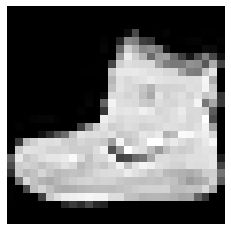

In [4]:
print(class_names[y_train[0]])
plt.imshow(X_train[0], cmap="gray")
plt.axis('off')
plt.show()

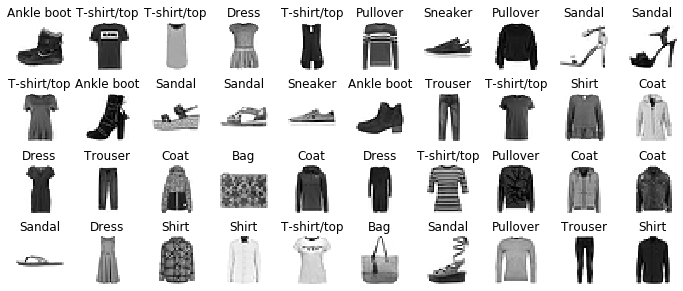

In [5]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

##### First Step: Creating a model using the Sequential API
<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch13/images/13_04.png?raw=true" alt="Activation functions" width="25%" style="float: right; margin-left: 0%;"/>

<img src="https://1.bp.blogspot.com/-svLN4YXrP5M/XAIe-GdhhJI/AAAAAAAANOo/s-HVNoMD8xMXZc0J-1n6JD903DIvq7ygwCLcBGAs/s1600/n9fgba8b0qr01.png" alt="Layers meme" width="30%" style="float: right; margin-left: 3%;"/>

- In the following, we will build a classification Multi-layer Perceptron with two hidden layers.
- To do so, we use the `Sequential` model provided by `keras`, which builds a simple neural net where many *layers* (the basic building blocks) are connected in a sequential manner, i.e. each layer is only getting input from the layer immediately before it. 
- `keras` supports many different activation functions. For a list of some popular ones, see the figure on the far right. 

In [6]:
keras.backend.clear_session() # This ensures that any previous runs don't interfere.
#np.random.seed(42)
#tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
hidden1 = model.layers[1] # can also use: hidden1 = model.get_layer("dense")
print("Layer name:   ", hidden1.name)

weights, biases = hidden1.get_weights()
print("Weights shape:", weights.shape)
print("Biases shape: ", biases.shape)

Layer name:    dense
Weights shape: (784, 300)
Biases shape:  (300,)


##### Second step: Compiling the model

- After model creation, you need to call `compile()` to specify the loss function, optimiser and metrics to use.
    * Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
    * Optimiser —This is how the model is updated based on the data it sees and its loss function.
    * Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified. [Ref](https://www.tensorflow.org/tutorials/keras/classification)

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
# can also use: 
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=keras.optimizers.SGD(),
#               metrics=[keras.metrics.sparse_categorical_accuracy])

##### Third step: Training and evaluating the model
<img src="https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch06/images/06_02.png" alt="Dataset splitting" width="35%" style="float:right; margin-left:3%;"  />  
- Finally, the model is ready. Simply call `fit()` to train (this is almost exactly the same as in sklearn). You need to specify the number of epochs, i.e. training cycles. 
- Specifying `validation_split` is not mandatory, but should usually be set to some small percentage. Keras will measure the loss and the extra metrics on a proportion (as specified) of the whole data set at the end of each epoch. **This helps massively in preventing overfitting.**  

*Note:* Training may take a while!

In [9]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 6s 104us/sample - loss: 0.7194 - accuracy: 0.7622 - val_loss: 0.5131 - val_accuracy: 0.8228
Epoch 2/30
54000/54000 [==============================] - 5s 93us/sample - loss: 0.4895 - accuracy: 0.8308 - val_loss: 0.4527 - val_accuracy: 0.8398
Epoch 3/30
54000/54000 [==============================] - 5s 93us/sample - loss: 0.4431 - accuracy: 0.8452 - val_loss: 0.4410 - val_accuracy: 0.8440
Epoch 4/30
54000/54000 [==============================] - 5s 93us/sample - loss: 0.4151 - accuracy: 0.8550 - val_loss: 0.4372 - val_accuracy: 0.8447
Epoch 5/30
54000/54000 [==============================] - 5s 94us/sample - loss: 0.3947 - accuracy: 0.8608 - val_loss: 0.4014 - val_accuracy: 0.8565
Epoch 6/30
54000/54000 [==============================] - 5s 96us/sample - loss: 0.3770 - accuracy: 0.8680 - val_loss: 0.4026 - val_accuracy: 0.8615
Epoch 7/30
54000/54000 [==============================] 

- The `fit()` function willl return a `History` object, which contains the training parameters, the list of epochs and most importantly, a dictionary `history.history`, which contains the loss and extra metrics at the end of each epoch for both the training and validation sets. 
- Using `pandas`, we can use the latter to plot the learning curves.

In [10]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1688,
 'samples': 54000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [11]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

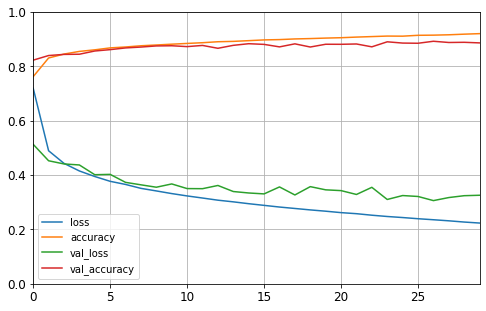

In [13]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set vertical range to [0-1]
plt.show()

- Both training accuracy and validation accuracy went up during training, while both loss metrics decreased. This indicates a good model.
- The validation curves are close to the training curves, which indicates that we do not have **overfitting**. 
- We can also see that the model has not quite yet converged. If you were to call the `fit()` function again, Keras would continue where it left off: 

In [14]:
history2 = model.fit(X_train, y_train, epochs=2, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - 5s 94us/sample - loss: 0.2199 - accuracy: 0.9201 - val_loss: 0.3137 - val_accuracy: 0.8882
Epoch 2/2
54000/54000 [==============================] - 5s 94us/sample - loss: 0.2168 - accuracy: 0.9211 - val_loss: 0.3176 - val_accuracy: 0.8880


- To evaluate, simply use `evaluate()` on the test datasets. 
- It is common to get a slightly lower performance on the test set compared to training. 
- Just like before, predictions can be make with `predict()`, however this time the function will output the **prediction probabilities**. You should use `predict_classes()` to output single classes (the one with the highest probability). 

In [15]:
evaluation = model.evaluate(X_test, y_test, verbose = 2)
print("Loss: ".ljust(12), evaluation[0])
print("Accuracy: ".ljust(12), evaluation[1])

10000/1 - 1s - loss: 0.2273 - accuracy: 0.8815
Loss:        0.33779060430526736
Accuracy:    0.8815


Probabilities:
[[0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.603 0.    0.397 0.    0.    0.    0.    0.   ]
 [0.286 0.    0.003 0.    0.001 0.    0.044 0.    0.666 0.   ]
 [0.416 0.    0.036 0.203 0.032 0.    0.3   0.    0.014 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.001 0.001 0.    0.002 0.    0.011 0.    0.969 0.015 0.001]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.998 0.    0.    0.001 0.   ]] 

Class predictions: [5 2 8 0 8 7 1 5 5]


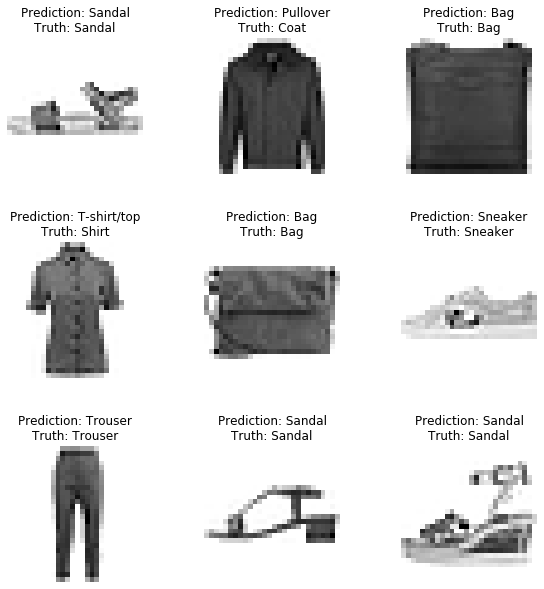

In [16]:
random_subset_indices = np.random.randint(0,X_test.shape[0], size=(9,))

X_new = X_test[random_subset_indices, :]
y_proba = model.predict(X_new)
print("Probabilities:")
print(y_proba.round(3), "\n")
y_pred = model.predict_classes(X_new)
y_pred
print("Class predictions:", y_pred)


plt.figure(figsize=(10, 10))
for index, image in enumerate(X_new):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title("Prediction: {}\nTruth: {}".format(
        class_names[y_pred[index]], 
        class_names[y_test[random_subset_indices[index]]]))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

<img src="https://3.bp.blogspot.com/-l25NV9Sy8to/XCZ5Ny-LS3I/AAAAAAAANkA/uoH7FGlbNyE_CrdQ-3RvASQP6MiL7eBOgCLcBGAs/s400/47446306_2163002007046355_8400391397395398656_n.png" alt="Tensorflow meme" width="30%" style="float: right; margin-left: 0%;"/>  
# Final Project


### Good luck!
